# Load

In [98]:
import patchseq_utils.analysis as utils
from patchseq_utils import plotting as plot
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# fix slow autocomplete
%config Completer.use_jedi = False

pd.set_option('use_inf_as_na', True)
pd.options.display.max_columns=300
pd.options.display.max_rows=300
sns.set(style='ticks', context='talk')
from importlib import reload

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [99]:
import patchseq_utils.plot.morphology as pm
import patchseq_utils.plot.sweeps as ps

In [100]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/l1_load.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  human_df['primary_ephys'] = human_df.eval('collaborator=="AIBS" & failed_fx_long_squares==False')


<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [101]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

In [102]:
mouse_df = mouse_df.loc[lambda df: df.structure.str.contains('VIS')].copy()
# TODO: edit in metadata?
human_df.layer.fillna(human_df.layer_lims, inplace=True)
mouse_df.layer.fillna(mouse_df.layer_lims, inplace=True)

human_all = human_df
human_aibs = human_df.query('collaborator=="AIBS" & failed_fx_long_squares==False')
mouse_l1 = mouse_df.loc[ lambda df: df['layer_ccf']=='1']
human_l1 = human_df.loc[ lambda df: df['layer']=='1']
# margin = 20
# mouse_l12 = mouse_df.loc[ lambda df: df['ccf_depth'] < 115 + margin]
# human_l12 = human_df.loc[ lambda df: (df['layer']=='1') | ((df['layer']=='2') & (df['layer_depth'] < margin))]
norm_cutoff = (248+40)/3077
human_df = human_df.assign(L12 = lambda df:  ((df['layer']=='2') & (df['layer_depth'] < 40)) |
                         (df['layer_depth'].isna() & (df['normalized_depth'] < norm_cutoff)) #currently doesn't catch any?
                           )
human_l12 = human_df.query("layer=='1' | L12")
mouse_df = mouse_df.assign(L12 = lambda df: ((df['layer']=='2/3') & (df['layer_depth'] < 40)) |
                           (df['layer'].isna() & (df['ccf_depth'] < 115+40))
                          )
mouse_l12 = mouse_df.query("layer=='1' | L12")
# human_l1 = human_df.loc[ lambda df: (df['soma_layer']==1)]

# TODO: fillna homology for L1 only??
combined_all_l1 = pd.concat([human_aibs.query("layer=='1'"), 
                             mouse_l1.query("failed_qc==False")], sort=False)
combined = combined_all_l1.dropna(subset=['homology_type']).copy()

combined_morph = pd.concat([human_l1, mouse_l1], 
                           sort=False).dropna(subset=['homology_type']).copy()
combined_l12 = pd.concat([human_l12, mouse_l12], 
                           sort=False).dropna(subset=['homology_type']).copy()

# include collab?
combined_all = pd.concat([human_df, mouse_df], sort=False)

In [103]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

# Stats

In [192]:
def summarize(df):
    results = {
        'Total patch-seq cell count': df.shape[0],
        'strict L1 cell count': df.query("strict_l1").shape[0],
        'ephys cell count': df.query("primary_ephys").shape[0],
        'morphology cell count': df.query("has_morph").shape[0],
    }
    return pd.Series(results)


In [103]:
subclass_counts = combined_l12.groupby(['species','homology_type'], observed=True).apply(summarize).astype(int)
ttype_counts = combined_l12.groupby(['species','t-type']).apply(summarize).astype(int)
totals = combined_l12.groupby(['species']).apply(summarize).astype(int)
totals.index = pd.MultiIndex.from_product([totals.index, ['total']])
count_summary = pd.concat([totals, subclass_counts, ttype_counts], sort=False)
count_summary

Total patch-seq cell count  \
species                                                     
human   total                                         250   
mouse   total                                         272   
human   LAMP5                                         113   
        MC4R                                           46   
        PAX6                                           48   
        L1 VIP                                         20   
        other                                          23   
mouse   LAMP5                                         202   
        MC4R                                           23   
        PAX6                                            4   
        L1 VIP                                         43   
human   ADARB2 MC4R                                    33   
        LAMP5 DBP                                      15   
        LAMP5 LCP2                                     16   
        LAMP5 NMBR                                     82   
        PAX6 CDH12                                     44   
        PAX6 TNFAIP8L3                                  4   
        SST BAGE2                                      12   
        SST CHRNA4                                     13   
        VIP PCDH20                                     11   
        VIP TSPAN12                                    20   
mouse   Lamp5 Fam19a1 Pax6                              6   
        Lamp5 Fam19a1 Tmem182                          17   
        Lamp5 Krt73                                     4   
        Lamp5 Lsp1                                     59   
        Lamp5 Ntn1 Npy2r                               49   
        Lamp5 Plch2 Dock5                              94   
        Sncg Vip Nptx2                                 17   
        Vip Col15a1 Pde1a                              26   

                               strict L1 cell count  ephys cell count  \
species                                                                 
human   total                                   231               194   
mouse   total                                   225               255   
human   LAMP5                                   103                96   
        MC4R                                     41                35   
        PAX6                                     47                33   
        L1 VIP                                   20                15   
        other                                    20                15   
mouse   LAMP5                                   179               187   
        MC4R                                     20                21   
        PAX6                                      3                 4   
        L1 VIP                                   23                43   
human   ADARB2 MC4R                              29                26   
        LAMP5 DBP                                13                12   
        LAMP5 LCP2                               14                13   
        LAMP5 NMBR                               76                71   
        PAX6 CDH12                               43                31   
        PAX6 TNFAIP8L3                            4                 2   
        SST BAGE2                                10                 6   
        SST CHRNA4                               12                 9   
        VIP PCDH20                               10                 9   
        VIP TSPAN12                              20                15   
mouse   Lamp5 Fam19a1 Pax6                        4                 6   
        Lamp5 Fam19a1 Tmem182                    16                15   
        Lamp5 Krt73                               3                 4   
        Lamp5 Lsp1                               45                53   
        Lamp5 Ntn1 Npy2r                         46                45   
        Lamp5 Plch2 Dock5                        88                89   
        Sncg Vip Nptx2

In [105]:
mde_morph = (subclass_counts.reset_index(level='species')
             .groupby('species')['morphology cell count'].apply(utils.pairwise_mde))

mde_ephys = (subclass_counts.reset_index(level='species')
             .groupby('species', squeeze=True)['ephys cell count'].apply(utils.pairwise_mde))

In [106]:
mde_summary = pd.concat([mde_morph.iloc[:,0].rename('morpho MDE: AUC for β=0.2'),
           mde_ephys.iloc[:,0].rename('ephys MDE: AUC for β=0.2')], axis=1)
mde_summary

morpho MDE: AUC for β=0.2  ephys MDE: AUC for β=0.2
species pair                                                             
human   LAMP5/MC4R                     0.717098                  0.619101
        LAMP5/PAX6                     0.685400                  0.621988
        LAMP5/L1 VIP                   0.834749                  0.668416
        LAMP5/other                    0.766246                  0.668416
        MC4R/PAX6                      0.737150                  0.650325
        MC4R/L1 VIP                    0.881990                  0.694033
        MC4R/other                     0.815016                  0.694033
        PAX6/L1 VIP                    0.855764                  0.695153
        PAX6/other                     0.785379                  0.695153
        L1 VIP/other                   0.916875                  0.737903
mouse   LAMP5/MC4R                     0.785412                  0.636835
        LAMP5/PAX6                     1.000000                  0.796442
        LAMP5/L1 VIP                   0.754015                  0.600479
        MC4R/PAX6                      1.000000                  0.847990
        MC4R/L1 VIP                    0.863711                  0.664919
        PAX6/L1 VIP                    1.000000                  0.823678

In [108]:
def q1(x): return x.quantile(0.25)
def q3(x): return x.quantile(0.75)
ephys_summary = pd.concat([
    combined_l12.groupby(['species','homology_type'], observed=True)[ephys_features].agg(
    ['mean', 'std', 'median', q1, q3]),
    combined_l12.groupby(['species','t-type'], observed=True)[ephys_features].agg(
    ['mean', 'std', 'median', q1, q3]),
])
morph_summary = pd.concat([
    combined_l12.groupby(['species','homology_type'], observed=True)[morph_features].agg(
    ['mean', 'std', 'median', q1, q3]),
    combined_l12.groupby(['species','t-type'], observed=True)[morph_features].agg(
    ['mean', 'std', 'median', q1, q3]),
])

In [111]:
with pd.ExcelWriter(figdir/'supp_tables'/'data_S2_subclass_subtype_statistics.xlsx',
                    mode="a", engine="openpyxl", if_sheet_exists="replace",) as writer: 
    # count_summary.to_excel(writer, sheet_name='Group cell counts')
    ephys_summary.to_excel(writer, sheet_name='Group electrophysiology features')
    morph_summary.to_excel(writer, sheet_name='Group morphology features')
    mde_summary.to_excel(writer, sheet_name='Subclass pair MDE')

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [199]:
def species_mde(counts, subclasses=['LAMP5','MC4R','PAX6','L1 VIP']):
    records = []
    for x in subclasses:
        records.append(dict(
            subclass=x,
            mde_auc=utils.mwu_mde_rho(counts.loc[('human',x)], counts.loc[('mouse',x)])
            ))
    return pd.DataFrame.from_records(records, index='subclass')

In [202]:
mde_species_morph = species_mde(subclass_counts['morphology cell count'])


mde_species_ephys = species_mde(subclass_counts['ephys cell count'])

mde_species = pd.concat([mde_species_morph.iloc[:,0].rename('morpho MDE: AUC for β=0.2'),
           mde_species_ephys.iloc[:,0].rename('ephys MDE: AUC for β=0.2')], axis=1)
mde_species

,morpho MDE: AUC for β=0.2,ephys MDE: AUC for β=0.2
subclass,,
LAMP5,0.666004,0.574267
MC4R,0.834923,0.672371
PAX6,1.000000,0.833818
L1 VIP,0.901984,0.687426


In [203]:
with pd.ExcelWriter(figdir/'supp_tables'/'data_S2_subclass_subtype_statistics.xlsx',
                    mode="a", engine="openpyxl", if_sheet_exists="replace",) as writer: 
    mde_species.to_excel(writer, sheet_name='Cross-species MDE by subclass')

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [7]:
len(human_df.query("collaborator=='AIBS' & failed_fx_long_squares==False & (layer=='1' | L12)"))

210

In [7]:
human_l12.to_csv(projectdir/"human_l1_dataset_strict.csv")

In [8]:
mouse_l12.to_csv(projectdir/"mouse_l1_dataset_strict.csv")

In [13]:
human_l12.layer.value_counts(dropna=False, normalize=True)

1    0.974265
2    0.025735
Name: layer, dtype: float64

In [11]:
mouse_l12.layer.value_counts(dropna=False)

NaN    176
1       75
2/3     21
Name: layer, dtype: int64

In [14]:
mouse_l12.layer_ccf.value_counts(dropna=False, normalize=True)

1      0.797794
2/3    0.202206
Name: layer_ccf, dtype: float64

# Dataset basics

In [6]:
data = combined.loc[combined[ephys_features].notna().sum(axis=1)>0]
morph_remove = [
    'soma_aligned_dist_from_pia',
    'basal_dendrite_frac_above_axon',
               ]
morph_features_compare = [x for x in morph_features if x not in morph_remove and '_pc' not in x]
morph_features_compare

['axon_bias_x',
 'axon_bias_y',
 'axon_emd_with_basal_dendrite',
 'axon_exit_distance',
 'axon_exit_theta',
 'axon_extent_x',
 'axon_extent_y',
 'axon_frac_above_basal_dendrite',
 'axon_frac_below_basal_dendrite',
 'axon_frac_intersect_basal_dendrite',
 'axon_max_branch_order',
 'axon_max_euclidean_distance',
 'axon_max_path_distance',
 'axon_mean_contraction',
 'axon_num_branches',
 'axon_soma_percentile_x',
 'axon_soma_percentile_y',
 'axon_total_length',
 'basal_dendrite_bias_x',
 'basal_dendrite_bias_y',
 'basal_dendrite_calculate_number_of_stems',
 'basal_dendrite_extent_x',
 'basal_dendrite_extent_y',
 'basal_dendrite_frac_below_axon',
 'basal_dendrite_frac_intersect_axon',
 'basal_dendrite_max_branch_order',
 'basal_dendrite_max_euclidean_distance',
 'basal_dendrite_max_path_distance',
 'basal_dendrite_mean_contraction',
 'basal_dendrite_mean_diameter',
 'basal_dendrite_num_branches',
 'basal_dendrite_soma_percentile_x',
 'basal_dendrite_soma_percentile_y',
 'basal_dendrite_stem

In [7]:
complete_features = np.array(ephys_features)[(data[ephys_features].notna().mean(axis=0)>0.80)]

data[ephys_features].notna().mean(axis=0).sort_values()

adp_v_last_rheo                           0.183673
sag_tau_depol                             0.229592
low_freq_impedance_chirp                  0.359694
peak_ratio_chirp                          0.359694
total_inductive_phase_chirp               0.364796
phase_peak_chirp                          0.364796
sync_freq_chirp                           0.364796
peak_impedance_chirp                      0.364796
3db_freq_chirp                            0.364796
peak_freq_chirp                           0.364796
phase_low_chirp                           0.364796
sag_tau                                   0.477041
mean_isi_rheo                             0.655612
first_isi_inv_rheo                        0.655612
sag_depol                                 0.846939
sag_area_depol                            0.852041
sag_peak_t_depol                          0.852041
ir_late_hero                              0.857143
ir_late_mean                              0.933673
adapt_hero                     

# Species diff

In [17]:
# combined_all = combined_all[~combined_all.homology_type.str.contains('other')]
# combined = combined[~combined.homology_type.str.contains('other')]

In [136]:
results = utils.run_twosamp(combined, complete_features, 'species')

results.head()

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
rheobase_i,1.292363e-58,0.950067,0.975034,9.555927e-79,1.555693,387,7.644742e-77,1.033890e-56
threshold_i_ramp,1.743952e-55,0.933239,0.966619,4.219284e-65,1.468957,380,1.687713e-63,6.975809e-54
tau,2.774334e-45,0.833969,0.916984,3.411127e-45,1.276947,386,9.096338e-44,7.398225e-44
input_resistance,4.745157e-42,0.802760,0.901380,3.024005e-43,1.255218,386,4.032007e-42,9.490314e-41
sag_area,1.871142e-38,0.713532,0.856766,1.516137e-44,1.268622,387,3.032275e-43,2.993828e-37


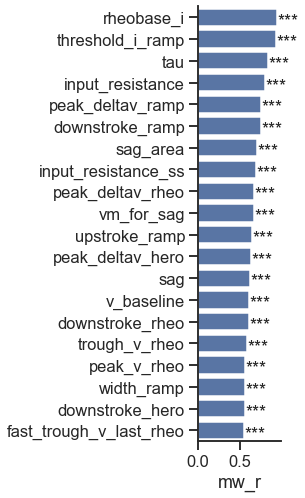

In [137]:
metric='mw_r'
pval='pval_mw_fdr'
utils.plot_feature_effect_sizes(results, pval=pval, val=metric)

In [138]:
corr = combined[complete_features].corr(method='spearman')
labels = {x: feature_name(x) for x in complete_features}
top_feat = utils.select_distinct(results.index, corr, threshold=0.85)

In [194]:
df = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool)).stack()
df.loc[lambda x: np.abs(x)>0.8]

upstroke_downstroke_ratio_ramp  upstroke_downstroke_ratio_rheo    0.823710
threshold_v_ramp                trough_v_ramp                     0.811838
                                threshold_v_rheo                  0.865206
                                threshold_v_hero                  0.835239
width_ramp                      upstroke_ramp                    -0.846419
                                downstroke_ramp                   0.922117
                                width_suprathresh_ramp            0.974961
                                downstroke_rheo                   0.801436
upstroke_ramp                   downstroke_ramp                  -0.905760
                                width_suprathresh_ramp           -0.820620
                                peak_deltav_ramp                  0.913078
                                upstroke_short_square             0.810883
                                upstroke_rheo                     0.872483
                         

Text(0.5, 0, 'r')

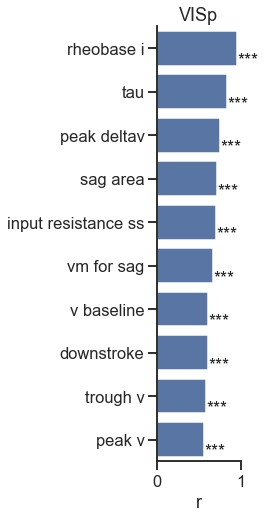

In [139]:
utils.plot_feature_effect_sizes(results.loc[top_feat], ylabels=labels,  pval=pval, val=metric)
plt.title('VISp')
plt.xlim(0, 1)
plt.xlabel('r')

In [29]:
results = utils.run_twosamp(combined_morph, morph_features, 'species')
# utils.plot_feature_effect_sizes(results, pval)
results.head(10)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
axon_mean_contraction,7.299803e-13,0.838500,0.919250,8.255622e-13,1.295485,106,4.210367e-11,3.722900e-11
soma_aligned_dist_from_pia,5.958625e-11,0.765021,0.882511,3.790361e-10,1.164491,106,9.665420e-09,1.519449e-09
basal_dendrite_num_branches,5.356896e-09,0.681975,0.840987,1.208306e-09,1.136226,106,2.054119e-08,9.106724e-08
axon_frac_above_basal_dendrite,8.122484e-08,0.619977,0.809989,3.505282e-07,0.976458,106,4.469235e-06,1.035617e-06
axon_frac_intersect_basal_dendrite,3.685100e-07,0.594336,0.797168,4.919256e-07,0.965537,106,5.017641e-06,3.758802e-06
basal_dendrite_mean_contraction,1.569946e-06,0.561424,0.780712,1.038584e-06,0.940792,106,8.827968e-06,1.334454e-05
basal_dendrite_max_branch_order,1.166555e-05,0.502105,0.751052,1.089129e-05,0.856229,106,7.935084e-05,8.499184e-05
basal_dendrite_extent_x_over_y,1.109615e-04,0.451971,0.725985,1.990879e-02,0.468374,106,5.343939e-02,6.287818e-04
axon_over_basal_dendrite_extent_x,1.109615e-04,0.451971,0.725985,1.446137e-03,0.633646,106,7.329009e-03,6.287818e-04


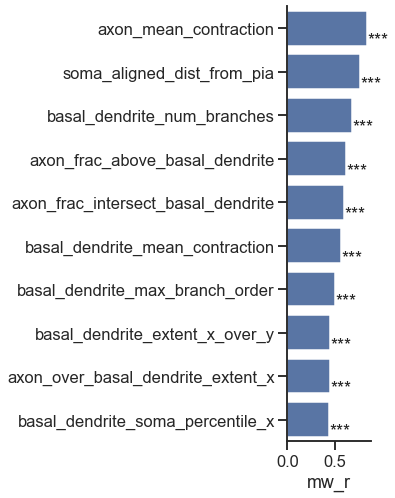

In [31]:
features = morph_features
corr = combined_morph[features].corr(method='spearman')
top_feat = utils.select_distinct(results.index, corr, threshold=0.85)
ylabels = {x: feature_name(x) for x in features}
utils.plot_feature_effect_sizes(results.loc[top_feat], pval=pval, val=metric)

## Stats dump

In [88]:
from statsmodels.stats.multitest import multipletests
from statsmodels.tools.sm_exceptions import ValueWarning
import scipy.stats as stats
import warnings
# warning from subtype not represented in mouse
warnings.filterwarnings("ignore", category=ValueWarning)


In [93]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

In [94]:
groups = ['PAX6', 'LAMP5', 'MC4R', 'L1 VIP']
results_e = utils.run_species_subclass_stats(combined, complete_features, groups=groups)
# results_e.to_csv(figdir/'supp_tables'/"cross_species_ephys_stats.csv")
results_e.head(10)

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in true_divide
  self.het_scale = (self.wresid / (1 - h))**2
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1922: RuntimeWarning: invalid value encountered in multiply
  scale[:, None] * self.model.pinv_wexog.T)


,eta_p_species,pval_species,pval_species:homology_type,rsquared,interaction,sig_groups,PAX6,LAMP5,MC4R,L1 VIP,auc_PAX6,auc_LAMP5,auc_MC4R,auc_L1 VIP
feature,,,,,,,,,,,,,,
rheobase_i,0.668440,1.831448e-91,1.872450e-08,0.703479,True,"PAX6, LAMP5, MC4R, L1 VIP",0.003786,3.053371e-38,5.591687e-09,0.000010,1.000000,0.983849,1.000000,0.930159
threshold_i_ramp,0.596994,3.282619e-74,1.147760e-08,0.639337,True,"PAX6, LAMP5, MC4R, L1 VIP",0.005124,4.720876e-35,8.177770e-09,0.000004,1.000000,0.967705,1.000000,0.955556
sag_area,0.508072,3.053557e-59,3.066555e-06,0.629684,True,"LAMP5, MC4R, L1 VIP",0.551968,3.937340e-35,4.567458e-08,0.000138,0.604167,0.904507,0.974048,0.874603
tau,0.502006,3.376226e-58,7.809116e-16,0.620327,True,"LAMP5, MC4R",0.083728,5.705227e-36,1.009351e-07,0.368947,0.812500,0.969679,0.961938,0.590476
input_resistance,0.486607,8.936048e-56,8.224858e-04,0.597335,True,"PAX6, LAMP5, MC4R, L1 VIP",0.002340,9.566825e-30,1.310450e-08,0.043227,0.967742,0.924408,0.993080,0.701587
sag,0.441797,4.683888e-49,1.652945e-16,0.678653,True,"LAMP5, MC4R, L1 VIP",0.062338,1.741526e-24,9.041024e-08,0.000026,0.833333,0.882632,0.963668,0.917460
peak_deltav_ramp,0.428973,2.211705e-46,5.194701e-03,0.461748,True,"LAMP5, MC4R",0.053170,2.023225e-25,1.198603e-04,0.058337,0.843750,0.894515,0.833910,0.688889
downstroke_ramp,0.421469,2.243426e-45,1.031378e-01,0.466418,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peak_deltav_rheo,0.371063,2.527019e-39,3.429497e-05,0.421942,True,"LAMP5, MC4R",0.124064,1.705065e-25,2.310168e-03,0.653270,0.781250,0.890987,0.764706,0.546032


In [95]:
results_m = utils.run_species_subclass_stats(combined_l12, morph_features_compare, groups=groups)
# results_m.to_csv(figdir/'supp_tables'/"cross_species_morpho_stats.csv")
results_m

,eta_p_species,pval_species,pval_species:homology_type,rsquared,interaction,sig_groups,PAX6,LAMP5,MC4R,L1 VIP,auc_PAX6,auc_LAMP5,auc_MC4R,auc_L1 VIP
feature,,,,,,,,,,,,,,
axon_mean_contraction,4.470218e-01,1.569941e-13,0.736526,0.511652,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_num_branches,3.698841e-01,8.158473e-11,0.803906,0.488387,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
axon_frac_above_basal_dendrite,2.816232e-01,6.032473e-08,0.089505,0.448297,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
axon_frac_intersect_basal_dendrite,2.428574e-01,7.655938e-07,0.736526,0.322526,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_mean_contraction,2.264627e-01,1.948255e-06,0.965626,0.316513,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_max_branch_order,1.916518e-01,1.768323e-05,0.736526,0.259383,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
axon_max_path_distance,1.709573e-01,6.020677e-05,0.196527,0.333190,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_soma_percentile_x,1.472651e-01,2.473858e-04,0.736526,0.200615,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
axon_over_basal_dendrite_extent_x,1.356048e-01,4.654843e-04,0.089505,0.284483,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
with pd.ExcelWriter(figdir/'supp_tables'/'data_S4_species_statistics.xlsx') as writer: 
# with pd.ExcelWriter(figdir/'supp_tables'/'data_S4_species_statistics.xlsx',
#                 mode="w", engine="openpyxl", if_sheet_exists="replace",) as writer: 
    results_m.to_excel(writer, sheet_name='Cross-species morphology')
    results_e.to_excel(writer, sheet_name='Cross-species electrophysiology')

## Morpho

In [234]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

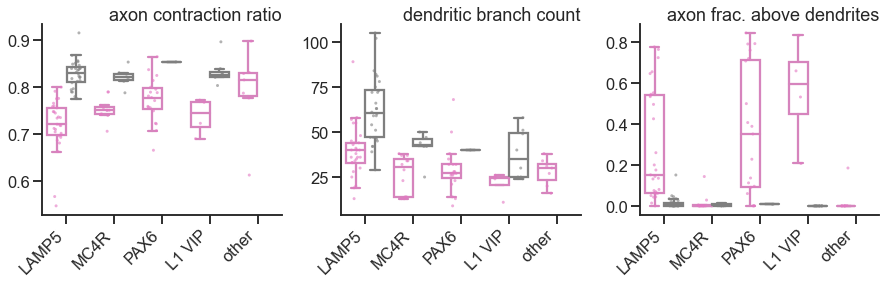

In [105]:
features = [
    'axon_mean_contraction',
    'basal_dendrite_num_branches',
    'axon_frac_above_basal_dendrite',
]
labels = [
    "axon contraction ratio",
     "dendritic branch count",
    'axon frac. above dendrites'
]
utils.plot_boxplot_multiple(data=combined_l12, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', fdr_method='fdr_bh',
               palette=species_palette, horizontal=True, figsize=(15,3.5),
                           test_subgroups=False)
save_plot_multiple(figdir/'f2_boxplots_morph_nostats', ['svg'])

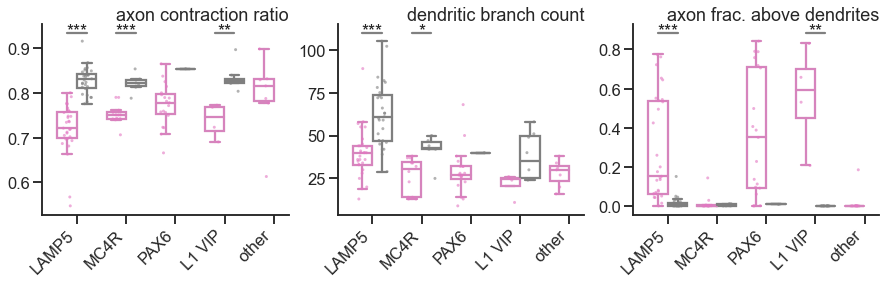

In [86]:
features = [
    'axon_mean_contraction',
    'basal_dendrite_num_branches',
    'axon_frac_above_basal_dendrite',
]
labels = [
    "axon contraction ratio",
     "dendritic branch count",
    'axon frac. above dendrites'
]
utils.plot_boxplot_multiple(data=combined_l12, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', fdr_method='fdr_bh',
               palette=species_palette, horizontal=True, figsize=(15,3.5))
save_plot_multiple(figdir/'f2_boxplots_morph', ['svg'])

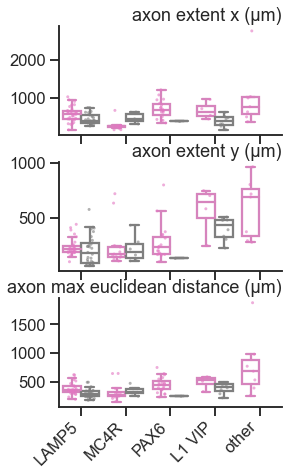

In [246]:
features = [
    'axon_extent_x',
    'axon_extent_y',
    'axon_max_euclidean_distance',
]
labels = [feature_name(x)+' (μm)' for x in features]
utils.plot_boxplot_multiple(data=combined_all, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False, fdr_method='fdr_bh', 
                            pad_title=5, space=0.25,
               palette=species_palette, figsize=(4,7))

save_plot_multiple(figdir/'s2_boxplots_axon', ['svg'])

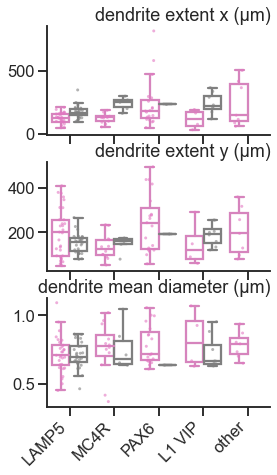

In [245]:
features = [
    'basal_dendrite_extent_x',
    'basal_dendrite_extent_y',
    'basal_dendrite_mean_diameter'
]
labels = [feature_name(x)+' (μm)' for x in features]
utils.plot_boxplot_multiple(data=combined_all, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False, fdr_method='fdr_bh',
                            pad_title=5, space=0.25,
               palette=species_palette, figsize=(4,7))

save_plot_multiple(figdir/'s2_boxplots_dendrites', ['svg'])

## Ephys

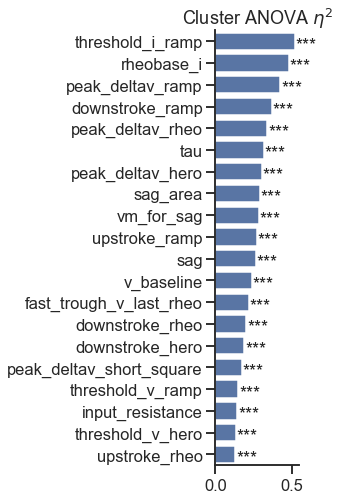

In [30]:
results = utils.run_cluster_anova(combined_all_l1, complete_features, cluster_var='species')

utils.plot_cluster_anova_bar(results, )

In [161]:
reload(plot)

<module 'plotting' from '/allen/programs/celltypes/workgroups/humancolumn_ephysmodeling/tom/projects/ephys_analysis/plotting.py'>

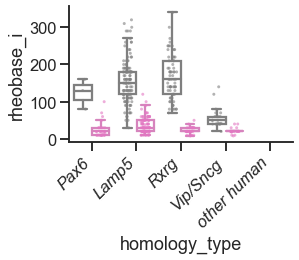

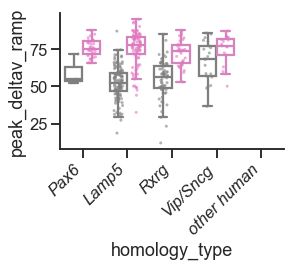

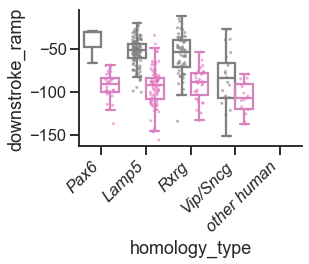

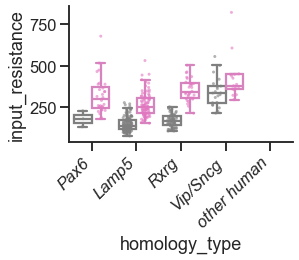

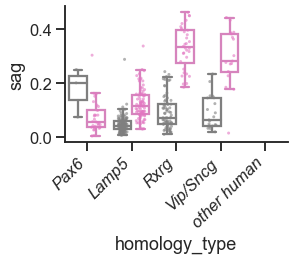

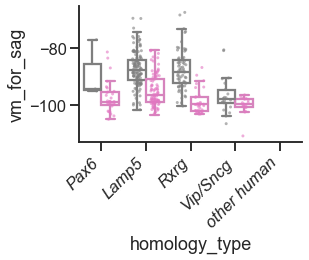

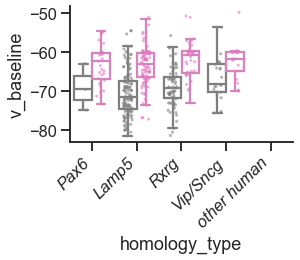

In [19]:
for y in ['rheobase_i', 'peak_deltav_ramp', 'downstroke_ramp', 'input_resistance', 'sag', 'vm_for_sag', 'v_baseline']:
    plot.box_strip(data=combined, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

In [84]:
def plot_e(y, label):
    plot.plot_nested_comparisons(data=combined, x='homology_type', y=y, compare='species', fdr_method='fdr_bh',
                       palette=species_palette, test_subgroups=results_e.loc[y, 'interaction'])
    plt.title(label)
    plt.ylabel('')
    plt.xlabel("subclass")

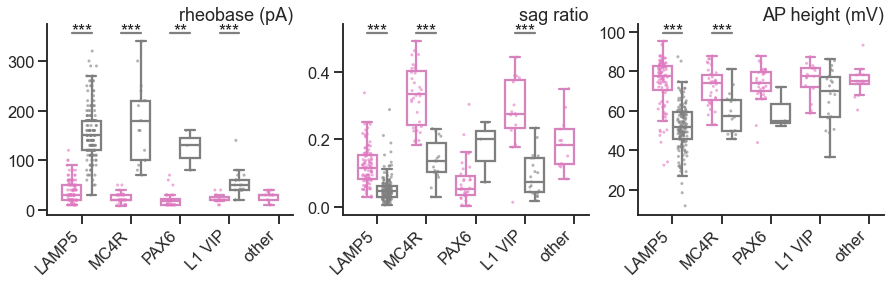

In [85]:
features = [
    'rheobase_i',
    'sag',
    'peak_deltav_ramp',
]
labels = [
   "rheobase (pA)",
    "sag ratio",
    "AP height (mV)"
]
utils.plot_boxplot_multiple(data=combined, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', fdr_method='fdr_bh',
               palette=species_palette, horizontal=True, figsize=(15,3.5))
save_plot_multiple(figdir/'f2_boxplots_ephys', ['svg'])

### Sag explanations

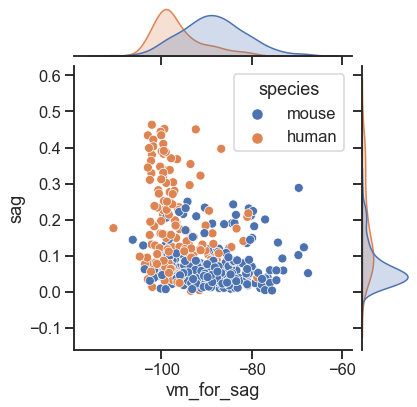

In [27]:
sns.jointplot(x='vm_for_sag',y='sag', data=combined, hue='species')

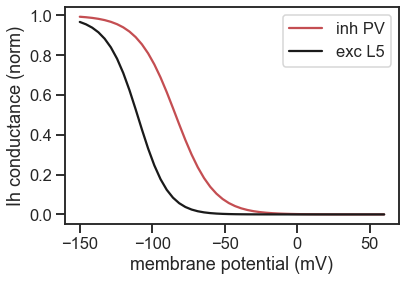

In [74]:
vtrap = lambda x,y: x / (np.exp(x / y) - 1)
mAlpha = lambda v: 0.001 * 6.43 * vtrap(v + 154.9, 11.9)
mBeta  =  lambda v: 0.001*193*np.exp(v/33.1)
ih_amp_exc = lambda v: mAlpha(v)/(mAlpha(v) + mBeta(v))
vm = -83.9
k = 13.1
# A = 1-0.08
A = 1
ih_amp = lambda v: A/(1 + np.exp((v-vm)/k)) + 1-A
v = np.linspace(-150, 60, 50)
plt.plot(v, ih_amp(v), 'r', label='inh PV')
plt.plot(v, ih_amp_exc(v), 'k', label='exc L5')
plt.ylabel('Ih conductance (norm)')
plt.xlabel('membrane potential (mV)')
plt.legend()

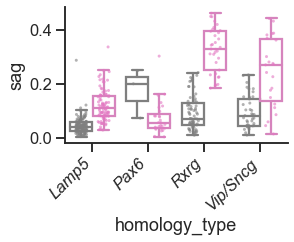

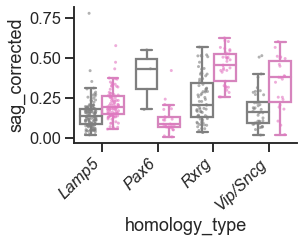

In [75]:
data = combined
fcn = ih_amp
g_base = 1/data.input_resistance
g_sag = g_base / (1-data.sag)
g_sag = g_base + (g_sag - g_base)/(fcn(data.vm_for_sag) - fcn(data.v_baseline))
data['sag_corrected'] = 1 - (g_base/g_sag)
plot.box_strip(data=data, x='homology_type', y='sag', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)
plot.box_strip(data=data, x='homology_type', y='sag_corrected', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)
# plt.ylim(0,5)

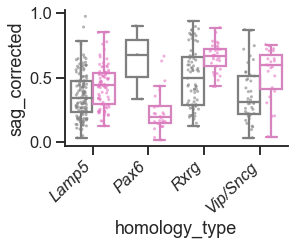

In [69]:
data = combined
fcn = ih_amp_exc
g_base = 1/data.input_resistance
g_sag = g_base / (1-data.sag)
g_sag = g_base + (g_sag - g_base)/(fcn(data.vm_for_sag) - fcn(data.v_baseline))
data['sag_corrected'] = 1 - (g_base/g_sag)
plot.box_strip(data=data, x='homology_type', y='sag_corrected', hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False)

### Schumann types?

Krt73/Fam19a1 as alpha7, Tmem182 (and lamb5 subset?) as canopy?

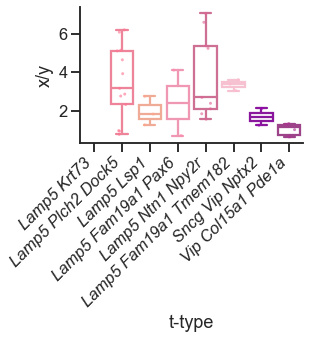

In [23]:
df = mouse_l1.copy()
df['x/y'] = df['axon_extent_x']/df['axon_extent_y']
plot.box_strip(data=df, x=cluster, y='x/y', hue=cluster, palette=palette_mouse, dodge=False)

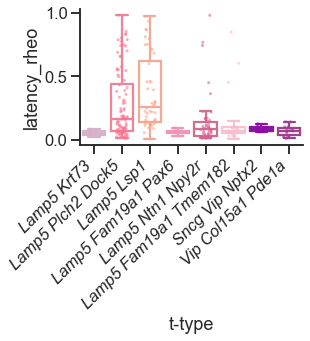

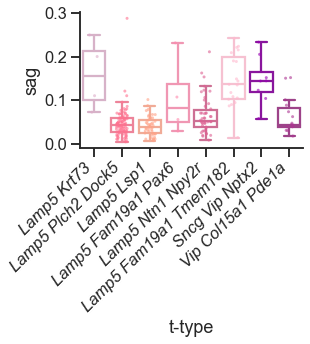

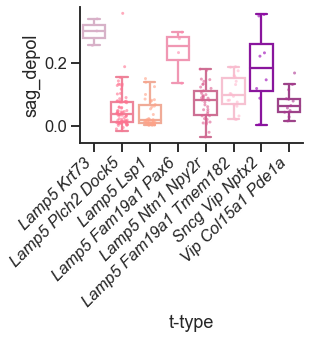

In [19]:
for y in ['latency_rheo', 'sag', 'sag_depol']:
    plot.box_strip(data=mouse_l1, x=cluster, y=y, hue=cluster, palette=palette_mouse, dodge=False)

## Gene-ephys

In [226]:
import ateam.data.shiny as shiny
def join_gene_data(df, genes_human, genes_mouse=None):
    join_on = 'sample_id'
    if genes_mouse and 'mouse' in df['species'].unique():
        genes_shared = [f"{gene_human}/{gene_mouse}" if gene_human != gene_mouse.upper() else gene_human
                    for gene_human, gene_mouse in zip(genes_human, genes_mouse)]
        data_human = (pd.read_feather(shiny.shiny_directory('human') + '/data.feather', columns=genes_human+[join_on])
                .rename(columns=dict(zip(genes_human, genes_shared))))
        data_mouse = (pd.read_feather(shiny.shiny_directory('mouse') + '/data.feather', columns=genes_mouse+[join_on])
                .rename(columns=dict(zip(genes_mouse, genes_shared))))
        gene_data = pd.concat([data_human, data_mouse], sort=False)
    else:
        gene_data = pd.read_feather(shiny.shiny_directory('human') + '/data.feather', columns=genes+[join_on])
        
    gene_data = (gene_data.set_index(join_on)
                .apply(lambda x: np.log2(x+1))
               )
    return df.join(gene_data, on=join_on, how='inner')

In [227]:
from scipy.stats import spearmanr
from statsmodels.stats import multitest
def gene_ephys_corr(data, genes, efeature):
    results = []
    for gene in genes:
        if gene not in data or data[gene].pipe(lambda x: sum(x>1)) < 5:
            continue
        df = data.dropna(subset=[gene, efeature])
        r, p = spearmanr(df[gene], df[efeature])
        out = {
        "gene":gene,
        "feature":efeature,
        'r':r,
        'p':p,
        }
        results.append(out)
    return results

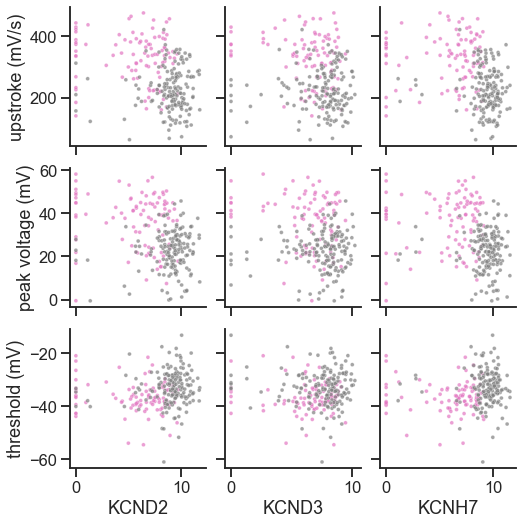

In [229]:
genes=['KCND2', 'KCND3', 'KCNH7',]
cells = combined.query("homology_type=='LAMP5' & primary_ephys")
joined_data = join_gene_data(cells, genes_human=genes, genes_mouse=[x.capitalize() for x in genes])
feat = [
    'upstroke_hero',
    # 'width_rheo', 
    'peak_v_hero',
    'threshold_v_hero',
]
names = [
    'upstroke (mV/s)', 
    # 'width (s)', 
    'peak voltage (mV)',
    'threshold (mV)'
]
g = sns.pairplot(data=joined_data.rename(columns=dict(zip(feat, names))), x_vars=genes, y_vars=names, hue='species', 
                 plot_kws=dict(alpha=0.7, s=15), palette=species_palette)
g._legend.remove()
save_plot_multiple(figdir/"s2_gene_ephys", ['svg'])

## Axon / dendrite histograms

In [8]:
path = Path("/allen/programs/celltypes/workgroups/mousecelltypes/Matt_Mallory/scripts/Feature_Calculation_Clean/Feature_Data/Mouse_Human_Inhib_L1_Lockdown/Human_Features_7_25_22/AlignedHistogram.csv")
hist_df = pd.read_csv(path, index_col='specimen_id')

In [9]:
dend_df = pd.DataFrame(index=hist_df.index)
comp = 2
n = 250//10
l1_upper_cols = [f"{comp}_{x}" for x in range(0, n)]
dend_df['axon_l1a'] = hist_df[l1_upper_cols].sum(axis=1)

cols = [f"{comp}_{x}" for x in range(n, 2*n)]
dend_df['axon_l1b'] = hist_df[cols].sum(axis=1)
dend_df['axon_all'] = hist_df[[x for x in hist_df.columns if f"{comp}_" in x]].sum(axis=1)
dend_df['L1b_axon_frac'] = dend_df['axon_l1b']/dend_df['axon_all']
dend_df['L1a_axon_frac'] = dend_df['axon_l1a']/dend_df['axon_all']


In [10]:
data = human_l1.join(dend_df)
# data = dend_df.join(human_df, how='inner')
# data = data.query("layer=='1' | layer=='2'")
# data.layer.value_counts()

In [23]:
pairs = [('LAMP5 LCP2','LAMP5 DBP')]

In [71]:
reload(utils)
reload(plot)

<module 'patchseq_utils.plotting' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/plotting.py'>

In [72]:
plot_multiple_grouped = lambda data, features, labels=None: utils.plot_boxplot_multiple(
    data, features, labels=labels, x='homology_type', palette_fine=palette_human, palette=palette_subclass,
    plot_function=plot.plot_subclass_focus, 
    subclasses=homology.keys(),  label_counts=False,
    pairs_fine='all', test='dunn', drop_box='other', figsize=(4,8))

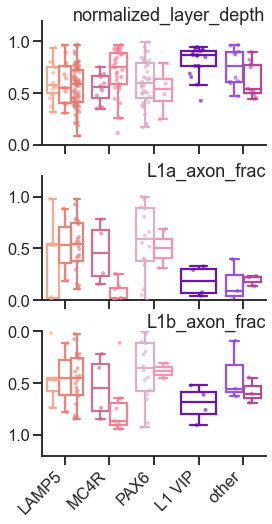

In [73]:
features = ['normalized_layer_depth', 'L1a_axon_frac', 'L1b_axon_frac',]

plot_multiple_grouped(data, features)
for ax in plt.gcf().axes:
    ax.set_ylim(0,1.2)
plt.gca().invert_yaxis()
# save_plot_multiple(figdir/"s6_sublaminar_human", ['svg'])


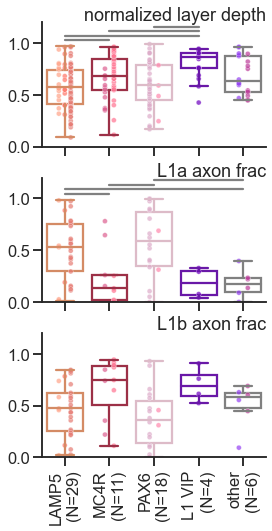

In [297]:

palette=palette_human
utils.plot_boxplot_multiple(
    data, features, labels=feature_name, x='homology_type', x_fine=cluster, 
    palette_fine=palette, palette=palette_subclass,
    pad_title=2,
    size=5, pairs='all', test='dunn', figsize=(4,8))
for ax in plt.gcf().axes:
    ax.set_ylim(0,1.2)
# plt.gca().invert_yaxis()
save_plot_multiple(figdir/"s6_sublaminar_human_stats", ['svg'])

In [74]:
# "/allen/programs/celltypes/workgroups/mousecelltypes/Matt_Mallory/scripts/Feature_Calculation_Clean/Feature_Data/Mouse_Human_Inhib_L1_Lockdown/Mouse_Features_7_25_22/AlignedHistogram.csv"

hist_df = pd.read_csv("../data/AlignedHistogram.csv", index_col='specimen_id')

In [75]:
dend_df = pd.DataFrame(index=hist_df.index)
comp = 2
n = 120//10
l1_upper_cols = [f"{comp}_{x}" for x in range(0, n)]
dend_df['axon_l1a'] = hist_df[l1_upper_cols].sum(axis=1)

cols = [f"{comp}_{x}" for x in range(n, 2*n)]
dend_df['axon_l1b'] = hist_df[cols].sum(axis=1)
dend_df['axon_all'] = hist_df[[x for x in hist_df.columns if f"{comp}_" in x]].sum(axis=1)
dend_df['L1b_axon_frac'] = dend_df['axon_l1b']/dend_df['axon_all']
dend_df['L1a_axon_frac'] = dend_df['axon_l1a']/dend_df['axon_all']



In [76]:
# data = dend_df.join(mouse_l1, how='inner')
# # data = data.query("layer=='1' | layer=='2/3'")
# # data = data.query("layer=='1'")
# data.layer.value_counts()
data = mouse_l1.join(dend_df)

In [81]:
plot_multiple_grouped = lambda data, features, labels=feature_name: utils.plot_boxplot_multiple(
    data, features, labels=labels, x='homology_type', palette_fine=palette_mouse, palette=palette_subclass,
    plot_function=plot.plot_subclass_focus, 
    subclasses=['LAMP5','MC4R','PAX6','L1 VIP'],  label_counts=False,
    pairs_fine='all', test='dunn', figsize=(4,8))

In [96]:
reload(plot)
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []
Empty DataFrame
Columns: [pvals, ipair, names, names_cat]
Index: []


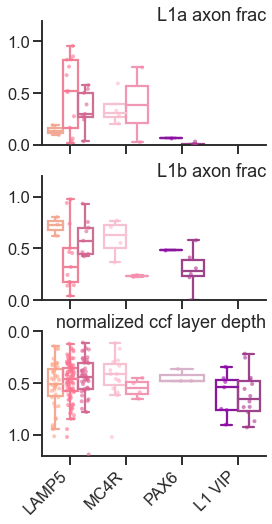

In [97]:
features = ['L1a_axon_frac', 'L1b_axon_frac', 'normalized_ccf_layer_depth']
# utils.plot_box_cluster_feature
data['normalized_ccf_layer_depth'] = data['ccf_depth']/115
# data = data[data[f] < 1]
plot_multiple_grouped(data, features)

for ax in plt.gcf().axes:
    ax.set_ylim(0,1.2)
plt.gca().invert_yaxis()
# save_plot_multiple(figdir/"s7_sublaminar_mouse", ['svg'])

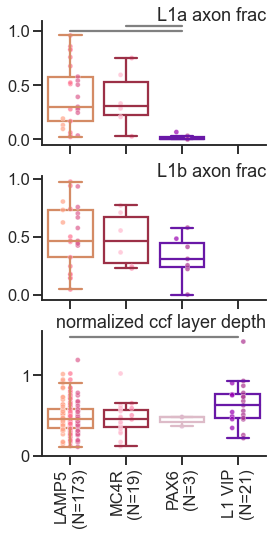

In [310]:

labels = feature_name
palette=palette_mouse
utils.plot_boxplot_multiple(
    data, features, labels=labels, x='homology_type', x_fine=cluster, palette_fine=palette, palette=palette_subclass,
                                  size=5, pairs='all', test='dunn', drop_box='other', figsize=(4,8))
# for ax in plt.gcf().axes:
#     ax.set_ylim(0,1)
# plt.gca().invert_yaxis()
save_plot_multiple(figdir/"s6_sublaminar_mouse_stats", ['svg'])

# within Lamp5 variability 

In [104]:
data = human_all_layers.loc[lambda df: df[cluster]=="LAMP5 LCP2"]
variable = 'normalized_depth'
features = [x for x in ephys_features if not '3' in x]
results = utils.run_regressions(data, morph_features, variable)
results.sort_values('pval_normalized_depth').head()

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1881: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of

,aic,bic,fvalue,f_pvalue,llf,rsquared,rsquared_adj,nobs,pval_normalized_depth,fval_normalized_depth,eta_p_normalized_depth,model,pval_normalized_depth_fdr
feature,,,,,,,,,,,,,
soma_aligned_dist_from_pia,118.083368,118.688538,94.994367,0.000010,-57.041684,0.942163,0.934933,10.0,0.000010,94.994367,0.922326,normalized_depth,0.000514
axon_emd_with_basal_dendrite,73.087317,73.692487,12.988377,0.006942,-34.543659,0.736180,0.703202,10.0,0.006942,12.988377,0.618837,normalized_depth,0.173562
axon_extent_y,131.656816,132.261986,9.569502,0.014812,-63.828408,0.603767,0.554238,10.0,0.014812,9.569502,0.544666,normalized_depth,0.246862
axon_depth_pc_0,167.843870,168.449040,6.922870,0.030125,-81.921935,0.369934,0.291176,10.0,0.030125,6.922870,0.463910,normalized_depth,0.321570
axon_extent_x_over_y,28.024940,28.630110,6.703551,0.032157,-12.012470,0.526667,0.467500,10.0,0.032157,6.703551,0.455914,normalized_depth,0.321570


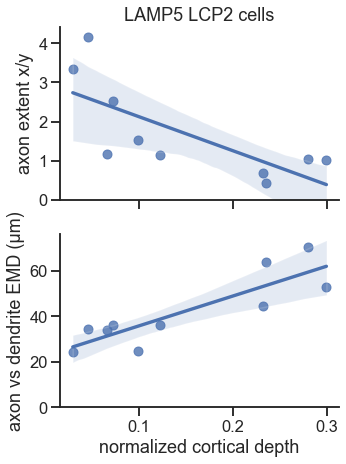

In [256]:
data = human_all_layers.loc[lambda df: df[cluster]=="LAMP5 LCP2"]

fig, axs = plt.subplots(figsize=(5,7), nrows=2, sharex=True)
plt.sca(axs[0])
x = 'normalized_depth'
y = 'axon_extent_x_over_y'
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
plt.title("LAMP5 LCP2 cells")
plt.ylabel("axon extent x/y")
plt.xlabel(None)

plt.sca(axs[1])
x = 'normalized_depth'
y = 'axon_emd_with_basal_dendrite'
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
plt.xlabel('normalized cortical depth')
plt.ylabel("axon vs dendrite EMD (μm)")
save_plot_multiple(figdir/"s2_lcp2_depth_trends", ['svg'])

In [ ]:
for y in ['axon_extent_x_over_y','axon_emd_with_basal_dendrite']:
    res = smf.ols(formula=formula, 
                  data=df_all.query(f"species=='{species}'")
                 ).fit(cov_type='HC3')
    print(res.rsquared, res.pvalues['input_resistance_sim'])

Text(0, 0.5, 'axon extent x/y')

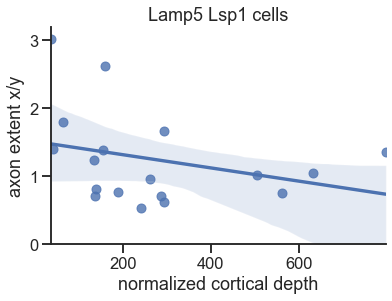

In [366]:
x = 'ccf_depth'
y = 'axon_extent_x_over_y'
data = mouse_df.loc[lambda df: df[cluster]=="Lamp5 Lsp1"]
sns.regplot(data=data, x=x, y=y)
# utils.plot_spearman(data, x, y)
plt.ylim(0,None)
sns.despine()
plt.title("Lamp5 Lsp1 cells")
plt.xlabel('normalized cortical depth')
plt.ylabel("axon extent x/y")

# Subclass Markers (supp table)

In [205]:
markers_mouse = pd.read_csv(projectdir/"mouse_markers_l1.csv").drop(columns="Unnamed: 0")
markers_human = pd.read_csv(projectdir/"human_markers_l1.csv").drop(columns="Unnamed: 0")

markers_mouse.gene = markers_mouse.gene.str.upper()

In [206]:
markers_mouse.head()

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
0,0.022,-1.677159,0.956,-2.375260,0.991,1.000,LAMP5,CNR1
1,0.045,-1.892848,0.910,-2.604682,0.702,1.000,LAMP5,CPLX2
2,0.951,2.352698,0.902,3.398354,0.985,0.391,LAMP5,MPPED1
3,0.947,3.225762,0.894,4.604369,0.907,0.107,LAMP5,TOX3
4,0.941,1.633286,0.882,2.366186,0.994,0.584,LAMP5,LAMP5


In [207]:
results = dict()
for cluster in markers_mouse.cluster.unique():
    human = markers_human.loc[lambda df: df.cluster==cluster].set_index('gene').drop(columns="cluster")
    mouse = markers_mouse.loc[lambda df: df.cluster==cluster].set_index('gene').drop(columns="cluster")
    results[cluster] = (human.join(mouse, rsuffix="_mouse", lsuffix="_human", how='inner')
                        .assign(min_power=lambda df: np.minimum(df.power_human, df.power_mouse))
                        .sort_values('min_power', ascending=False)
                        .loc[:, lambda df: df.columns.insert(0, 'min_power')])

In [208]:
markers_human.loc[lambda df:  (df.cluster=="LAMP5" )& (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
0,0.989,NaN,0.978,NaN,0.987,0.438,LAMP5,SV2C
1,0.989,NaN,0.978,NaN,0.995,0.929,LAMP5,PTPRT
2,0.972,381.225303,0.944,549.991854,1.000,0.844,LAMP5,CACNA2D1
4,0.969,393.020709,0.938,567.009027,1.000,0.803,LAMP5,GRIA4
5,0.956,NaN,0.912,NaN,0.997,0.603,LAMP5,PTCHD4


In [209]:
markers_mouse.loc[lambda df: (df.cluster=="LAMP5" )& (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
2,0.951,2.352698,0.902,3.398354,0.985,0.391,LAMP5,MPPED1
3,0.947,3.225762,0.894,4.604369,0.907,0.107,LAMP5,TOX3
4,0.941,1.633286,0.882,2.366186,0.994,0.584,LAMP5,LAMP5
8,0.934,2.665271,0.868,3.873192,0.998,0.848,LAMP5,NPY
13,0.924,1.118577,0.848,1.603227,1.000,0.945,LAMP5,FGF13


In [210]:
results["LAMP5"].head()

,min_power,myAUC_human,avg_diff_human,power_human,avg_log2FC_human,pct.1_human,pct.2_human,myAUC_mouse,avg_diff_mouse,power_mouse,avg_log2FC_mouse,pct.1_mouse,pct.2_mouse,min_power
gene,,,,,,,,,,,,,,
LAMP5,0.854,0.927,NaN,0.854,NaN,0.897,0.149,0.941,1.633286,0.882,2.366186,0.994,0.584,0.854
NPAS3,0.828,0.072,NaN,0.856,NaN,0.977,1.000,0.086,-1.608473,0.828,-2.308102,0.429,1.000,0.828
SV2C,0.804,0.989,NaN,0.978,NaN,0.987,0.438,0.902,2.825705,0.804,4.085799,0.848,0.099,0.804
NRXN3,0.798,0.101,-166.091725,0.798,-239.619708,1.000,1.000,0.080,-1.032628,0.840,-1.545613,0.999,1.000,0.798
MPPED1,0.784,0.892,NaN,0.784,NaN,0.990,0.587,0.951,2.352698,0.902,3.398354,0.985,0.391,0.784


In [211]:
markers_human.loc[lambda df: (df.cluster=="PAX6") & (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
87,0.983,42.137980,0.966,60.792254,1.000,0.938,PAX6,RALYL
89,0.960,136.683420,0.920,197.192492,0.979,0.289,PAX6,MAN1A1
93,0.923,37.978177,0.846,54.790928,1.000,0.968,PAX6,ENOX1
97,0.907,-175.140586,0.814,-252.674455,0.979,0.765,PAX6,FAM19A2
99,0.895,528.201934,0.790,762.034311,0.885,0.447,PAX6,PDZRN4


In [216]:
markers_human.query("gene=='PAX6'")

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene


In [212]:
markers_mouse.loc[lambda df: (df.cluster=="PAX6") & (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
816,0.993,1.866028,0.986,2.690732,1.000,0.871,PAX6,RALYL
817,0.993,3.101766,0.986,4.446526,1.000,0.331,PAX6,DPY19L1
818,0.992,2.245987,0.984,3.178394,1.000,0.627,PAX6,ELMO1
819,0.985,3.099569,0.970,4.662760,1.000,0.252,PAX6,PAX6
820,0.976,3.682631,0.952,5.385695,0.965,0.046,PAX6,ANO3


In [213]:
results["PAX6"].head()

,min_power,myAUC_human,avg_diff_human,power_human,avg_log2FC_human,pct.1_human,pct.2_human,myAUC_mouse,avg_diff_mouse,power_mouse,avg_log2FC_mouse,pct.1_mouse,pct.2_mouse,min_power
gene,,,,,,,,,,,,,,
RALYL,0.966,0.983,42.137980,0.966,60.792254,1.000,0.938,0.993,1.866028,0.986,2.690732,1.000,0.871,0.966
ZMAT4,0.916,0.042,-476.543016,0.916,-687.506246,0.604,0.971,0.026,-2.461367,0.948,-3.472004,0.456,0.997,0.916
PRKCB,0.728,0.071,-219.482567,0.858,-316.646411,0.865,0.997,0.136,-0.917142,0.728,-1.329642,1.000,0.998,0.728
CACNA2D1,0.680,0.094,-604.992742,0.812,-872.820029,0.677,0.949,0.160,-1.344938,0.680,-1.985215,0.825,0.970,0.680
PROX1,0.680,0.160,NaN,0.680,NaN,0.146,0.765,0.074,-2.824259,0.852,-4.100004,0.140,0.904,0.680


In [217]:
markers_human.loc[lambda df: (df.cluster=="MC4R") & (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
213,0.934,NaN,0.868,NaN,1.000,0.990,MC4R,SORCS1
215,0.905,229.242797,0.810,330.727446,1.000,0.952,MC4R,ASIC2
217,0.896,243.019611,0.792,350.603188,0.980,0.772,MC4R,TSHZ2
219,0.892,77.828240,0.784,112.282416,0.967,0.747,MC4R,FAM19A1
225,0.857,20.512255,0.714,29.592928,0.987,0.845,MC4R,NELL2


In [220]:
markers_human.query("gene=='MC4R'")

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene


In [218]:
markers_mouse.loc[lambda df: (df.cluster=="MC4R") & (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
645,0.958,2.081596,0.916,2.836338,1.000,0.587,MC4R,DEPTOR
646,0.938,1.284293,0.876,1.836716,1.000,0.994,MC4R,OGFRL1
647,0.917,1.807441,0.834,2.502644,0.989,0.285,MC4R,SORCS1
649,0.912,0.884869,0.824,1.313112,1.000,0.973,MC4R,NECAB1
650,0.910,0.871987,0.820,1.244197,1.000,1.000,MC4R,APP


In [219]:
results["MC4R"].head()

,min_power,myAUC_human,avg_diff_human,power_human,avg_log2FC_human,pct.1_human,pct.2_human,myAUC_mouse,avg_diff_mouse,power_mouse,avg_log2FC_mouse,pct.1_mouse,pct.2_mouse,min_power
gene,,,,,,,,,,,,,,
SORCS1,0.834,0.934,NaN,0.868,NaN,1.000,0.990,0.917,1.807441,0.834,2.502644,0.989,0.285,0.834
NXPH1,0.750,0.125,NaN,0.750,NaN,0.470,0.868,0.102,-3.915906,0.796,-5.682991,0.148,0.840,0.750
TOX2,0.636,0.163,NaN,0.674,NaN,0.325,0.780,0.182,-2.172162,0.636,-3.168985,0.181,0.756,0.636
RALYL,0.548,0.226,-129.024342,0.548,-186.142779,0.901,0.955,0.868,0.955693,0.736,1.402323,1.000,0.860,0.548
BRINP2,0.540,0.230,NaN,0.540,NaN,0.490,0.818,0.191,-2.030651,0.618,-2.976556,0.434,0.836,0.540


In [221]:
markers_human.loc[lambda df: (df.cluster=="VIP") & (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
293,0.909,104.946937,0.818,151.406426,1.000,0.771,VIP,TRPM3
296,0.885,82.353896,0.770,118.811557,1.000,0.999,VIP,KCNQ5
299,0.873,NaN,0.746,NaN,0.946,0.541,VIP,CDH11
301,0.869,-42.824095,0.738,-61.782109,1.000,1.000,VIP,NRXN3
304,0.860,NaN,0.720,NaN,1.000,0.916,VIP,PRKD1


In [224]:
markers_human.query("gene=='VIP'")

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
349,0.77,NaN,0.54,NaN,0.676,0.14,VIP,VIP


In [222]:
markers_mouse.loc[lambda df: (df.cluster=="VIP") & (df.myAUC>0.5)].head(5)

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
211,0.992,3.662818,0.984,5.286911,0.992,0.462,VIP,SYNPR
212,0.991,3.509570,0.982,5.091537,1.000,0.265,VIP,CPNE2
213,0.990,2.157149,0.980,3.119872,1.000,0.833,VIP,FXYD6
215,0.989,3.989671,0.978,5.750891,0.992,0.317,VIP,HTR3A
217,0.975,3.120205,0.950,4.323411,0.992,0.307,VIP,THSD7A


In [225]:
markers_mouse.query("gene=='VIP'")

,myAUC,avg_diff,power,avg_log2FC,pct.1,pct.2,cluster,gene
227,0.961,7.245704,0.922,10.925182,0.976,0.706,VIP,VIP


In [223]:
results["VIP"].head()

,min_power,myAUC_human,avg_diff_human,power_human,avg_log2FC_human,pct.1_human,pct.2_human,myAUC_mouse,avg_diff_mouse,power_mouse,avg_log2FC_mouse,pct.1_mouse,pct.2_mouse,min_power
gene,,,,,,,,,,,,,,
RGS7,0.794,0.103,-168.096390,0.794,-242.511828,1.000,1.000,0.067,-2.228437,0.866,-3.265346,0.315,0.951,0.794
NRXN3,0.738,0.869,-42.824095,0.738,-61.782109,1.000,1.000,0.959,1.135938,0.918,1.684096,1.000,0.999,0.738
BRINP2,0.734,0.133,NaN,0.734,NaN,0.108,0.789,0.107,-3.195655,0.786,-4.668575,0.129,0.846,0.734
CACNA2D1,0.690,0.098,-626.940886,0.804,-904.484506,0.568,0.934,0.155,-1.329921,0.690,-1.848991,0.758,0.982,0.690
GRIK1,0.690,0.140,NaN,0.720,NaN,0.973,0.976,0.155,-1.884547,0.690,-2.620270,0.573,0.932,0.690


# Combined ANOVA

## Ephys

In [80]:
# exclude sag peak time, simply not valid for mouse
features = set(complete_features).difference(['sag_peak_t'])
ylabels = {x:feature_name(x) for x in features}
group_list = ['human','mouse']
data = combined.query("core_l1_type")
corr_filter = data[features].corr()

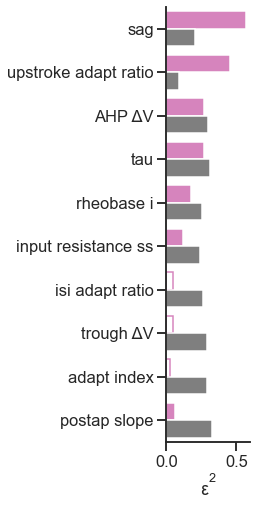

In [81]:
cluster_var = "homology_type"
effect='epsilon2'
results_list = [utils.run_kw_dunn(
    data.query(f"species=='{x}'"), features, cluster_var, posthoc=False)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect=effect, pval='pval_fdr', rank='max',
    corr_filter=corr_filter, corr_thresh=0.7, nfeat=10)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_fdr', val=effect, 
    ylabels=ylabels, palette=species_palette)
plt.xlabel('$\epsilon^2$')
save_plot_multiple(figdir/'f2_anova_ephys', ['svg'])

In [82]:
res

,KW_H,pval,epsilon2,pval_fdr,KW_H,pval,epsilon2,pval_fdr,max,diff
,human,human,human,human,mouse,mouse,mouse,mouse,,
feature,,,,,,,,,,
sag,99.666127,1.833509e-21,0.569521,1.448472e-19,41.144127,6.094743e-09,0.205721,2.407423e-08,0.569521,0.363800
upstroke_adapt_ratio,78.326576,7.013535e-17,0.452755,2.770346e-15,17.819529,4.791990e-04,0.091382,7.010503e-04,0.452755,0.361373
fast_trough_deltav_hero,46.845000,3.749730e-10,0.267686,4.937144e-09,59.191153,8.750492e-13,0.295956,1.728222e-11,0.295956,-0.028270
tau,47.363389,2.908890e-10,0.270648,4.596047e-09,61.652566,2.606821e-13,0.309812,6.864630e-12,0.309812,-0.039164
rheobase_i,30.945368,8.728633e-07,0.176831,3.629274e-06,50.680617,5.721813e-11,0.253403,4.109302e-10,0.253403,-0.076572
input_resistance_ss,20.938291,1.084288e-04,0.121031,3.172546e-04,48.572954,1.608179e-10,0.242865,9.074727e-10,0.242865,-0.121834
isi_adapt_ratio,8.252771,4.106657e-02,0.047704,6.159376e-02,50.481852,6.307737e-11,0.258881,4.152594e-10,0.258881,-0.211177
trough_slowdeltav_hero,8.238984,4.132240e-02,0.047080,6.159376e-02,58.127685,1.476226e-12,0.290638,2.007917e-11,0.290638,-0.243559


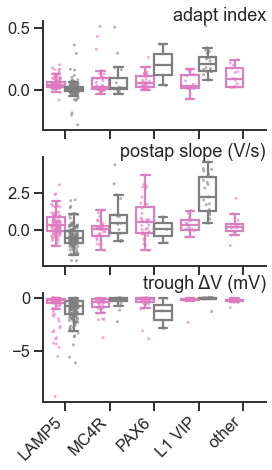

In [249]:
features = [
    'adapt_mean',
    'postap_slope_hero',
    'trough_slowdeltav_hero',
]
labels = [feature_name(x) for x in features]
labels[1] += ' (V/s)'
labels[2] += ' (mV)'
utils.plot_boxplot_multiple(data=combined, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False,
               palette=species_palette, figsize=(4,7))
save_plot_multiple(figdir/'s2_boxplots_mouse_ephys', ['svg'])

## Morph

In [76]:
features = morph_features_compare
ylabels = {x:feature_name(x) for x in features}
group_list = ['human','mouse']
data = combined_l12.query("core_l1_type")
corr_filter = data[features].corr()

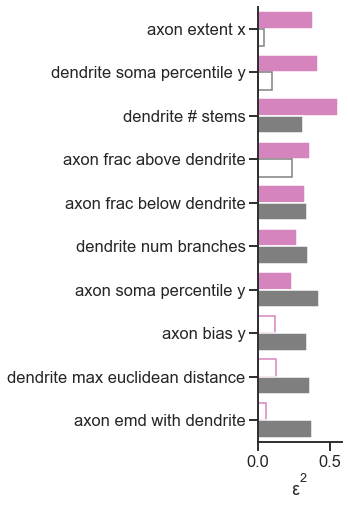

In [77]:
cluster_var = "homology_type"
effect='epsilon2'
results_list = [utils.run_kw_dunn(
    data.query(f"species=='{x}'"), features, cluster_var, posthoc=False)
                for x in group_list]

res = utils.compile_feature_effects_comparison(
    results_list, group_list, effect=effect, pval='pval_fdr', rank='max',
    corr_filter=corr_filter, corr_thresh=0.75, nfeat=10)

utils.plot_feature_effects_comparison_barplot(
    res, pval='pval_fdr', val=effect, 
    ylabels=ylabels, palette=species_palette)
plt.xlabel('$\epsilon^2$')
save_plot_multiple(figdir/'f2_anova_morph', ['svg'])

In [78]:
res

,KW_H,pval,epsilon2,pval_fdr,KW_H,pval,epsilon2,pval_fdr,max,diff
,human,human,human,human,mouse,mouse,mouse,mouse,,
feature,,,,,,,,,,
axon_extent_x,24.101101,2.379486e-05,0.382557,0.000349,1.811688,0.612395,0.043135,0.709089,0.382557,0.339422
basal_dendrite_soma_percentile_y,26.378855,7.944895e-06,0.418712,0.000175,4.138478,0.246894,0.098535,0.362111,0.418712,0.320177
basal_dendrite_calculate_number_of_stems,35.052775,1.187371e-07,0.556393,0.000005,13.283384,0.004062,0.316271,0.019860,0.556393,0.240122
axon_frac_above_basal_dendrite,22.972031,4.092875e-05,0.364635,0.000450,10.029062,0.018321,0.238787,0.053741,0.364635,0.125848
axon_frac_below_basal_dendrite,20.595049,1.277596e-04,0.326906,0.001124,14.450877,0.002351,0.344069,0.017195,0.344069,-0.017163
basal_dendrite_num_branches,17.327101,6.052804e-04,0.275033,0.002959,14.614567,0.002177,0.347966,0.017195,0.347966,-0.072933
axon_soma_percentile_y,14.885476,1.917179e-03,0.236277,0.007140,17.855935,0.000471,0.425141,0.017195,0.425141,-0.188864
axon_bias_y,7.649015,5.385073e-02,0.121413,0.087757,14.509174,0.002288,0.345457,0.017195,0.345457,-0.224044


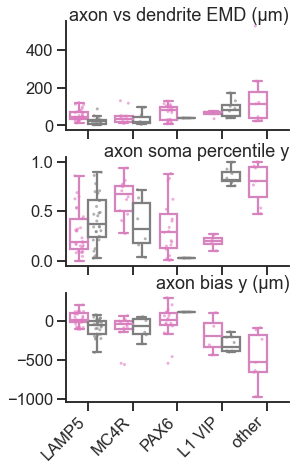

In [253]:
features = [
    'axon_emd_with_basal_dendrite',
    'axon_soma_percentile_y',
    'axon_bias_y',
]
labels = [feature_name(x) for x in features]
labels[0] = 'axon vs dendrite EMD (μm)'
labels[2] += ' (μm)'
utils.plot_boxplot_multiple(data=combined_l12, x='homology_type', features=features, labels=labels,
                            plot_function=plot.plot_nested_comparisons, compare='species', 
                            test_subgroups=False,
               palette=species_palette, figsize=(4,7))
# save_plot_multiple(figdir/'supp_mouse_anova_boxplots_morph', ['svg'])
save_plot_multiple(figdir/'s2_boxplots_mouse_morph', ['svg'])

# Species examples

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


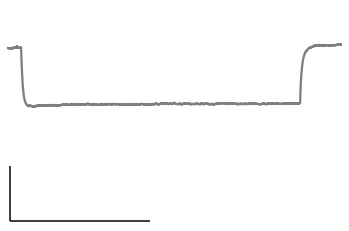

In [31]:
feat = 'sag'
cell = mouse_df.query("homology_type=='LAMP5'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[0]
dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True)
ps.plot_sag(dataset, sweeps, color=species_palette['mouse'], 
            n_max=1, scalebar=True, dy=40, loc='lower left')

save_plot_multiple(figdir/'f2_sag_m', ['svg'])

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


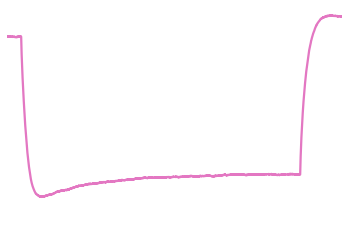

In [32]:
feat = 'sag'
cell = human_df.query("homology_type=='LAMP5'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[0]
dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True)
ps.plot_sag(dataset, sweeps, color=species_palette['human'], n_max=1, scalebar=False, dy=40, loc='upper left')

save_plot_multiple(figdir/'f2_sag_h', ['svg'])

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


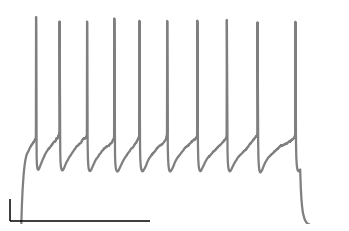

In [47]:
feat = 'peak_deltav_ramp'
cell = mouse_df.query("homology_type=='LAMP5'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[0]
dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True)
ps.plot_spikes(dataset, sweeps, color=species_palette['mouse'], 
            n_max=1, scalebar=True, dy=100, loc='lower left')

# save_plot_multiple(figdir/'f2_sag_m', ['svg'])

In [56]:
reload(ps)

<module 'patchseq_utils.plot.sweeps' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/plot/sweeps.py'>

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


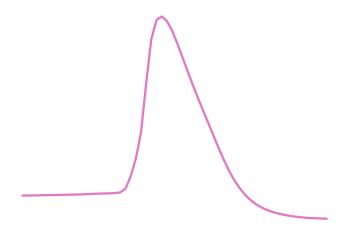

In [59]:
feat = 'peak_deltav_ramp'
cell = human_df.query("homology_type=='LAMP5'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[0]
dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True)
ps.plot_rheo_spikes(dataset, sweeps, color=species_palette['human'], 
             scalebar=False, dy=100, loc='lower left')

save_plot_multiple(figdir/'f2_spike_h', ['svg'])

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.4 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


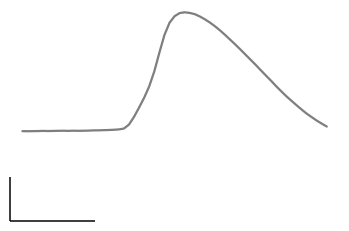

In [60]:
feat = 'peak_deltav_ramp'
cell = mouse_df.query("homology_type=='LAMP5'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[0]
dataset, sweeps = ps.get_dataset_sweeps(cell, lims_sweep_info=True, qc_sweeps=True)
ps.plot_rheo_spikes(dataset, sweeps, color=species_palette['mouse'], 
             scalebar=True, dy=100, loc='lower left')

save_plot_multiple(figdir/'f2_spike_m', ['svg'])

In [38]:
output_mappings = {
    'Gabor': lambda sample_id: f"/home/tom.chartrand/projects/data/u01/tamas/output/{sample_id}/output.json",
    'Huib': lambda sample_id: f"/home/tom.chartrand/projects/data/u01/mansvelder/output/{sample_id}/output.json",
    'AIBS': lambda sample_id: f"/home/tom.chartrand/projects/data/u01/aibs/output/{sample_id}/output.json"
}
import ipfx.bin.features_from_output_json as out
import allensdk.core.json_utilities as ju

In [36]:

def plot_fi_curve(cell, species='human', **kwargs):
    if species=='human':
        df = human_df
        output_json = f"/home/tom.chartrand/projects/data/u01/aibs/output/{cell}/output.json"
    else:
        df = mouse_df
        output_json = f"/home/tom.chartrand/projects/data/u01/aibs_mouse/output/{cell}/output.json"
    cell_entry = df.loc[cell]
    # output_json = output_mappings[cell_entry['collaborator']](cell_entry.name)
    output = ju.read(output_json)
    sweeps = out.get_sweeps_df(output, features=['avg_rate'])
    sweeps_plot = sweeps.loc[lambda df: (df['avg_rate']>0) & (df['passed'])]
    plt.figure(figsize=(3,2))
    sns.lineplot(data=sweeps_plot, x='stimulus_amplitude', y='avg_rate', 
                 color=species_palette[species], **kwargs)
    plt.xlim(0, 250)
    plt.ylim(0, 30)
    plt.xlabel('I (pA)')
    plt.ylabel('f (Hz)')
    plt.yticks([0,30])
    sns.despine()
    

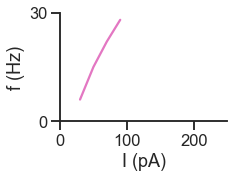

In [39]:
feat = 'rheobase_i'
cell = human_df.query("homology_type=='LAMP5' & collaborator=='AIBS'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[0]
plot_fi_curve(cell)
save_plot_multiple(figdir/'f2_fi_h', ['svg'])

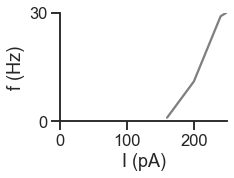

In [45]:
feat = 'rheobase_i'
cell = mouse_df.query("homology_type=='LAMP5'").loc[
    lambda df: df[feat]==df[feat].quantile(interpolation='nearest')].index[2]
plot_fi_curve(cell, species='mouse')
save_plot_multiple(figdir/'f2_fi_m', ['svg'])

# K channel recordings

In [6]:
channels_df = pd.read_csv("/home/tom.chartrand/projects/human_l1/L1_homologous_channel_cells.csv", index_col=1)
channels_df.head()

,Unnamed: 0,total_v_half,total_slope,slow_v_half,slow_slope,fast_v_half,fast_slope,sus_v_half,sus_slope,total_peak_current,total_current_density,total_conductance,total_conductance_density,slow_peak_current,slow_current_density,slow_conductance,slow_conductance_density,fast_peak_current,fast_current_density,fast_conductance,fast_conductance_density,organism,Tree_first_cl,Tree_call,cell_name_label,Tree_first_cl_color,L1_homologous_type
cell_name,,,,,,,,,,,,,,,,,,,,,,,,,,,
H19.03.305.11.10.01.06,11,-6.370183,13.678684,NaN,NaN,7.456774,17.809239,NaN,NaN,864.770813,6.744556,5.086887,0.039674,NaN,NaN,NaN,NaN,557.171082,4.345511,3.277477,0.025562,human,Inh L1 SST CHRNA4 (ADARB2+),PoorQ,H19.03.305.11.10.01.06,#73FF7B,Rxrg
Ndnf-IRES2-dgCre;Ai14-470195.04.02.02,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mouse,Lamp5 Plch2 Dock5,Core,Ndnf-IRES2-dgCre;Ai14-470195.04.02.02,#FF7290,Lamp5
H19.03.319.11.04.01.01,54,-10.453496,9.909890,-18.446655,11.155533,2.644184,15.032388,33.617053,13.161699,1041.547607,5.805377,6.126751,0.034149,608.312988,3.390614,3.578312,0.019945,561.033752,3.127089,3.300199,0.018395,human,Inh L1 SST NMBR (ADARB2+),Core,H19.03.319.11.04.01.01,#3DCC52,Lamp5
H19.03.323.11.04.01.05,77,1.428486,14.016928,NaN,NaN,-40.481452,44.257497,NaN,NaN,511.423248,2.604785,3.008372,0.015322,NaN,NaN,NaN,NaN,322.330353,1.641696,1.896061,0.009657,human,Inh L1-2 GAD1 MC4R (ADARB2+),I1,H19.03.323.11.04.01.05,#179935,Rxrg
H19.06.351.11.16.02.03,125,15.516560,10.017801,9.238993,11.119369,4.466508,59.810200,-3.398264,2.273635,1598.805298,7.144319,9.404737,0.042025,1400.537842,6.258353,8.238458,0.036814,439.679016,1.964721,2.586347,0.011557,human,Inh L1-2 LAMP5 DBP,I2,H19.06.351.11.16.02.03,#00FF50,Lamp5


In [7]:
channels = combined_morph.join(channels_df, on='cell_name', rsuffix='_r', how='inner')
channels = channels.query('homology_type!="L1 VIP"')
channels.homology_type.cat.remove_unused_categories(inplace=True)

In [8]:
channels.groupby(['homology_type','species']).slow_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
LAMP5          human      7.0
               mouse      2.0
MC4R           human      2.0
               mouse      NaN
PAX6           human      1.0
               mouse      NaN
Name: slow_conductance_density, dtype: float64

In [9]:
channels.groupby(['homology_type','species']).fast_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
LAMP5          human      9.0
               mouse      4.0
MC4R           human      4.0
               mouse      NaN
PAX6           human      2.0
               mouse      NaN
Name: fast_conductance_density, dtype: float64

In [10]:
channels.groupby(['homology_type','species']).total_conductance_density.apply(lambda x: x.notna().sum())

homology_type  species
LAMP5          human      10.0
               mouse       5.0
MC4R           human       5.0
               mouse       NaN
PAX6           human       4.0
               mouse       NaN
Name: total_conductance_density, dtype: float64

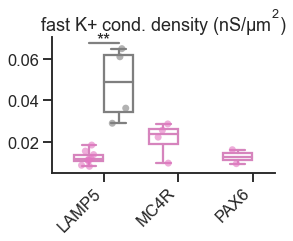

In [19]:
y = "fast_conductance_density"
plot.plot_nested_comparisons(data=channels, x='homology_type', y=y, compare='species', 
                   palette=species_palette, size=7)
plt.xlabel(None)
plt.ylabel(None)
plt.title("fast K+ cond. density ($nS/\mu m^2$)")
save_plot_multiple(figdir/'f2_k_channel_boxplot', ['pdf','svg'])

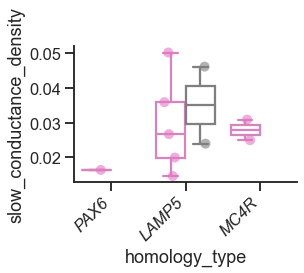

In [309]:
y = "slow_conductance_density"
plot.box_strip(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)

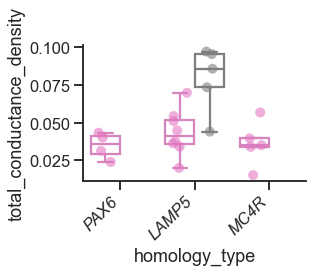

In [311]:
y = "total_conductance_density"
plot.plot_nested_comparisons(data=channels, x='homology_type', y=y, hue='species', 
                   palette=species_palette, dodge=True, legend=False, notch=False, size=10)